#2. Machine Learning solutions mindset

#Business use case 3: Solution to classify social media comments sentiments (positive or negative).

##Importing libraries and loading the dataset.

In [1]:
import pandas as pd
import numpy as np

import re
import sys

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

from textblob import TextBlob
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
tweets_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
tweets_df.head(5) #head function for data showing purposes

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


##Cleaning the data

In [3]:
#Create a function to remove clean the text

def clean_Tweet(text):
  text = re.sub('@[A-Za-z0-9]+','',text) #Remove mentions
  text = re.sub('#','', text) #Remove hashtags
  text = re.sub('http[s]?://+' , '', text) #Remove url's
  text = re.sub('<.*?>', '', text) #Remove html tags
  return text  

In [4]:
tweets_df['text'] = tweets_df['text'].apply(lambda x : clean_Tweet(x))

In [5]:
#Create a function to remove emojis

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [6]:
tweets_df['text'] = tweets_df['text'].apply(lambda x : remove_emoji(x))

##Obtain Subjectivity and polarity

In [7]:
#Create a function to obtain subjectivity
def obtainSubj(text):
  return TextBlob(text).sentiment.subjectivity

In [8]:
#Create column for Subjectivity

tweets_df['Subjectivity'] = tweets_df['text'].apply(obtainSubj)

In [9]:
#Create a function to obtain polarity
def obtainPol(text):
  return TextBlob(text).sentiment.polarity

In [10]:
#Create column for Polarity

tweets_df['Polarity'] = tweets_df['text'].apply(obtainPol)

In [11]:
#Show data with the new columns

tweets_df.head()

,id,keyword,location,text,target,Subjectivity,Polarity
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,0.0000,0.00000
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.4000,0.10000
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.3875,-0.01875
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,0.0000,0.00000
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,0.0000,0.00000


##Get the analysis of the polarity

In [12]:
#Creating a function to determine if positive, negative or neutral
def getAnalysis(polarity):
  if polarity < 0:
    return 'Negative'
  elif polarity > 0:
    return 'Positive'
  else:
    return 'Neutral'

def infoAnalysis(polarity):
  if polarity < 0:
    return -1
  elif polarity > 0:
    return 1
  else:
    return 0

In [13]:
#Create column for Analysis

tweets_df['Analysis'] = tweets_df['Polarity'].apply(getAnalysis)
tweets_df['Info_Analysis'] = tweets_df['Polarity'].apply(infoAnalysis)

In [14]:
#Show data with the new columns

tweets_df.head(5)

,id,keyword,location,text,target,Subjectivity,Polarity,Analysis,Info_Analysis
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,0.0000,0.00000,Neutral,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.4000,0.10000,Positive,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.3875,-0.01875,Negative,-1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,0.0000,0.00000,Neutral,0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,0.0000,0.00000,Neutral,0


Neutral     3571
Positive    2452
Negative    1590
Name: Analysis, dtype: int64

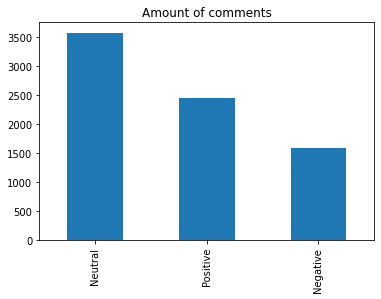

In [15]:
#Create a barplot to show the amount of neutral, positive and negative tweets.

tweets_df.Analysis.value_counts().plot.bar(title="Amount of comments")
tweets_df.Analysis.value_counts()

##Preprocessing the data

In [16]:
#Counting the number of unique words in the dataset

def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [17]:
text_values = tweets_df["text"]

counter = counter_word(text_values)
print("The training dataset has {} unique words".format(len(counter)))

The training dataset has 29292 unique words


In [18]:
#Lowering the cases in the tweets

tweets_df['text'] = tweets_df['text'].str.lower()

In [19]:
#Removing the stopwords

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [20]:
tweets_df['text'] = tweets_df['text'].apply(lambda x : clean_text(x))

In [21]:
#Strip the tweets
tweets_df['text'] = tweets_df['text'].str.strip()

##Splitting in test and training

In [22]:
# Initialize variables
from math import ceil

vocab_size = len(counter)
embedding_dim = 16
max_length = 30
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>" # Generic token to words out of vocabulary
training_size = ceil(tweets_df.shape[0]*0.8) # 80% of training data

In [23]:
# Create training subsets
training_sentences = tweets_df.text[0:training_size]
training_labels = tweets_df.Info_Analysis[0:training_size]
# Create testing subsets
testing_sentences  = tweets_df.text[training_size:]
testing_labels = tweets_df.Info_Analysis[training_size:]

## Tokenization

In [24]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fitting the training dataset
tokenizer.fit_on_texts(training_sentences)
# Create a words dictionary
word_index = tokenizer.word_index

## Sequencing

In [25]:
# Create sequences of tokens that represent each sentence 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

## Padding

In [26]:
# Create padding sequences for training sentences 
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)
# Create padding sequences for testing sentences 
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

#Modeling and training

In [27]:
# Convert the sets to array to get it to work with TensorFlow 2
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [28]:
# Reference https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences
# Create a model
model = tf.keras.Sequential([
    # Embedding layer for NN                         
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),    
    # Global Average pooling is similar to adding up vectors
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(12, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                             
])

In [29]:
#Compiling the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [30]:
#Training the model
epoch_num = 10
history = model.fit(training_padded, 
                    training_labels, 
                    epochs = epoch_num, 
                    validation_data = (testing_padded, testing_labels), verbose = 2)

Epoch 1/10
191/191 - 2s - loss: 0.5741 - accuracy: 0.4787 - val_loss: 0.5672 - val_accuracy: 0.4258 - 2s/epoch - 11ms/step
Epoch 2/10
191/191 - 1s - loss: 0.4963 - accuracy: 0.4799 - val_loss: 0.5559 - val_accuracy: 0.4258 - 1s/epoch - 6ms/step
Epoch 3/10
191/191 - 1s - loss: 0.4834 - accuracy: 0.4799 - val_loss: 0.5492 - val_accuracy: 0.4258 - 1s/epoch - 6ms/step
Epoch 4/10
191/191 - 1s - loss: 0.4520 - accuracy: 0.4975 - val_loss: 0.5280 - val_accuracy: 0.4336 - 1s/epoch - 6ms/step
Epoch 5/10
191/191 - 1s - loss: 0.3890 - accuracy: 0.5795 - val_loss: 0.4920 - val_accuracy: 0.4855 - 1s/epoch - 6ms/step
Epoch 6/10
191/191 - 1s - loss: 0.3220 - accuracy: 0.6800 - val_loss: 0.4603 - val_accuracy: 0.5355 - 1s/epoch - 6ms/step
Epoch 7/10
191/191 - 1s - loss: 0.2777 - accuracy: 0.7362 - val_loss: 0.4422 - val_accuracy: 0.5637 - 1s/epoch - 6ms/step
Epoch 8/10
191/191 - 1s - loss: 0.2521 - accuracy: 0.7610 - val_loss: 0.4302 - val_accuracy: 0.5696 - 1s/epoch - 6ms/step
Epoch 9/10
191/191 - 1s

In [31]:
score = model.evaluate(testing_padded, testing_labels, verbose=1)
print("Accuracy: ", score[1])

48/48 [==============================] - 0s 2ms/step - loss: 0.4195 - accuracy: 0.5953
Accuracy:  0.5952693819999695


# Predicting

In [37]:
# predict clases because is classification problem with the split test
predict_x = model.predict(testing_padded)   
predictions = np.argmax(predict_x,axis=1)

In [38]:
# Sequencing
submission_sequences = tokenizer.texts_to_sequences(test_df.text)
# Padding
submission_padded = pad_sequences(submission_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [39]:
predictions = model.predict(submission_padded)

In [40]:
# sample of submission
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [41]:
# Add target column to submission file
submission['target'] = (predictions > 0.5).astype(int)
submission.head(10)

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,1
9,29,0
